使用AlexNet网络对Cifar10进行分类
===

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

# 2.导入数据

In [5]:
train_indices = torch.arange(0, 48000)
valid_indices = torch.arange(48000, 50000)


train_transform = transforms.Compose([transforms.Resize((70, 70)),
                                      transforms.RandomCrop((64, 64)),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((70, 70)),
                                     transforms.CenterCrop((64, 64)),
                                     transforms.ToTensor()])

train_and_valid = datasets.CIFAR10(root='/data/input/', 
                                   train=True, 
                                   transform=train_transform,
                                   download=False)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)
test_dataset = datasets.CIFAR10(root='/data/input/', 
                                train=False, 
                                transform=test_transform,
                                download=False)




train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

In [6]:

# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])


# 3.模型

In [8]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4.训练

In [9]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/040 | Batch 000/188 | Cost: 2.3027
Epoch: 001/040 | Batch 150/188 | Cost: 1.8155
Epoch: 001/040
Train ACC: 34.25 | Validation ACC: 34.50
Time elapsed: 0.46 min
Epoch: 002/040 | Batch 000/188 | Cost: 1.7891
Epoch: 002/040 | Batch 150/188 | Cost: 1.4934
Epoch: 002/040
Train ACC: 46.66 | Validation ACC: 47.25
Time elapsed: 0.81 min
Epoch: 003/040 | Batch 000/188 | Cost: 1.3608
Epoch: 003/040 | Batch 150/188 | Cost: 1.3044
Epoch: 003/040
Train ACC: 53.04 | Validation ACC: 53.15
Time elapsed: 1.15 min
Epoch: 004/040 | Batch 000/188 | Cost: 1.2723
Epoch: 004/040 | Batch 150/188 | Cost: 1.3227
Epoch: 004/040
Train ACC: 54.43 | Validation ACC: 53.15
Time elapsed: 1.49 min
Epoch: 005/040 | Batch 000/188 | Cost: 1.2138
Epoch: 005/040 | Batch 150/188 | Cost: 1.2562
Epoch: 005/040
Train ACC: 60.52 | Validation ACC: 60.30
Time elapsed: 1.83 min
Epoch: 006/040 | Batch 000/188 | Cost: 1.0441
Epoch: 006/040 | Batch 150/188 | Cost: 1.1029
Epoch: 006/040
Train ACC: 63.89 | Validation ACC: 62.

# 5.评估

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

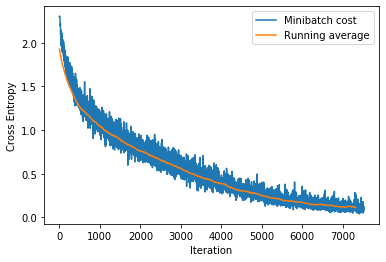

In [11]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()

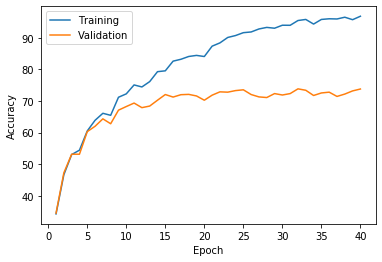

In [12]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [13]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 73.00%
Test ACC: 73.31%
